Nama : Anindhita Nisitasari

# Intro and Importing Dataset

In [5]:
from google.colab import files
import io

# dataframe
import pandas as pd
import re


# split data
from sklearn.model_selection import train_test_split

# preprocessing dan layer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# visualisasi plot
import matplotlib.pyplot as plt

In [8]:
! chmod 600 /content/kaggle.json

In [9]:
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d hgultekin/bbcnewsarchive

  0% 0.00/1.81M [00:00<?, ?B/s]
100% 1.81M/1.81M [00:00<00:00, 86.8MB/s]


In [10]:
import zipfile
zip_file = zipfile.ZipFile('/content/bbcnewsarchive.zip', 'r')
zip_file.extractall('/tmp/')

In [23]:
df = pd.read_csv("/tmp/bbc-news-data.csv", sep='\t')
df.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [24]:
# total data
df.shape

(2225, 4)

In [25]:
# Mengecek apakah ada nilai Null
df.isnull().sum()

category    0
filename    0
title       0
content     0
dtype: int64

In [26]:
# cek memory usage
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   filename  2225 non-null   object
 2   title     2225 non-null   object
 3   content   2225 non-null   object
dtypes: object(4)
memory usage: 69.7+ KB
None


In [27]:
# Kategori
df.category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [28]:
# Menghapus kolom yang tidak digunakan
df = df.drop(columns=['filename'])
df

,category,title,content
0,business,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
...,...,...,...
2220,tech,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,Be careful how you code,A new European directive could put software w...
2223,tech,US cyber security chief resigns,The man making sure US computer networks are ...


In [31]:
#menggabungkan column title dan content
df['text'] = df['title'] + " " + df['content']
df

,category,title,content,text
0,business,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,Ad sales boost Time Warner profit Quarterly p...
1,business,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,Dollar gains on Greenspan speech The dollar h...
2,business,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,Yukos unit buyer faces loan claim The owners ...
3,business,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,High fuel prices hit BA's profits British Air...
4,business,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,Pernod takeover talk lifts Domecq Shares in U...
...,...,...,...,...
2220,tech,BT program to beat dialler scams,BT is introducing two initiatives to help bea...,BT program to beat dialler scams BT is introd...
2221,tech,Spam e-mails tempt net shoppers,Computer users across the world continue to i...,Spam e-mails tempt net shoppers Computer user...
2222,tech,Be careful how you code,A new European directive could put software w...,Be careful how you code A new European direct...
2223,tech,US cyber security chief resigns,The man making sure US computer networks are ...,US cyber security chief resigns The man makin...


# DATA CLEANING

In [32]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.preprocessing import text, sequence
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [33]:
#Deleting Stopwords

stwd = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stwd.update(punctuation)

In [34]:
# data cleaning
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#deleting square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
#deleting URL's
def remove_url(text):
    return re.sub(r'http\S+', '', text)
#deleting stopwords dari text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stwd:
            final_text.append(i.strip())
    return " ".join(final_text)
#deleting noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_url(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['text']=df['text'].apply(denoise_text)

# Encoding and Splitting Data

In [35]:
# data category one-hot-encoding
category = pd.get_dummies(df.category)
new_cat = pd.concat([df, category], axis=1)
new_cat = new_cat.drop(columns='category')
new_cat.head(10)

,title,content,text,business,entertainment,politics,sport,tech
0,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,Ad sales boost Time Warner profit Quarterly pr...,1,0,0,0,0
1,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,Dollar gains Greenspan speech dollar hit highe...,1,0,0,0,0
2,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,Yukos unit buyer faces loan claim owners embat...,1,0,0,0,0
3,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,High fuel prices hit BA's profits British Airw...,1,0,0,0,0
4,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,Pernod takeover talk lifts Domecq Shares UK dr...,1,0,0,0,0
5,Japan narrowly escapes recession,Japan's economy teetered on the brink of a te...,Japan narrowly escapes recession Japan's econo...,1,0,0,0,0
6,Jobs growth still slow in the US,The US created fewer jobs than expected in Ja...,Jobs growth still slow US US created fewer job...,1,0,0,0,0
7,India calls for fair trade rules,"India, which attends the G7 meeting of seven ...","India calls fair trade rules India, attends G7...",1,0,0,0,0
8,Ethiopia's crop production up 24%,Ethiopia produced 14.27 million tonnes of cro...,Ethiopia's crop production 24% Ethiopia produc...,1,0,0,0,0
9,Court rejects $280bn tobacco case,A US government claim accusing the country's ...,Court rejects $280bn tobacco case US governmen...,1,0,0,0,0


In [36]:
# change dataframe value to numpy array
news = new_cat['text'].values
label = new_cat[['business', 'entertainment', 'politics', 'sport', 'tech']].values

In [37]:
news

array(['Ad sales boost Time Warner profit Quarterly profits US media giant TimeWarner jumped 76% $1.13bn (£600m) three months December, $639m year-earlier. firm, one biggest investors Google, benefited sales high-speed internet connections higher advert sales. TimeWarner said fourth quarter sales rose 2% $11.1bn $10.9bn. profits buoyed one-off gains offset profit dip Warner Bros, less users AOL. Time Warner said Friday owns 8% search-engine Google. internet business, AOL, mixed fortunes. lost 464,000 subscribers fourth quarter profits lower preceding three quarters. However, company said AOL\'s underlying profit exceptional items rose 8% back stronger internet advertising revenues. hopes increase subscribers offering online service free TimeWarner internet customers try sign AOL\'s existing customers high-speed broadband. TimeWarner also restate 2000 2003 results following probe US Securities Exchange Commission (SEC), close concluding. Time Warner\'s fourth quarter profits slightly be

In [38]:
label

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]], dtype=uint8)

# SPLIT DATASET

In [39]:
x_train,x_test,y_train,y_test = train_test_split(news, label,test_size = 0.2,shuffle=True)

# Tokenizer and Sequential Model with Embedding and LSTM

In [40]:
vocab_size = 10000
max_len = 200
trunc_type = "post"
oov_tok = ""

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)

word_index = tokenizer.word_index

sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)
pad_train = pad_sequences(sequences_train, maxlen=max_len, truncating=trunc_type)
pad_test = pad_sequences(sequences_test, maxlen=max_len, truncating=trunc_type)

print(pad_test.shape)

(445, 200)


In [41]:
pad_train

array([[   1, 1656, 2104, ...,   86, 1858, 2787],
       [   0,    0,    0, ...,  174,  774,    1],
       [   0,    0,    0, ...,   20,  188,   62],
       ...,
       [ 674,   51,  588, ..., 2050,    1,    1],
       [2055,  294, 6116, ...,  502,  565,    8],
       [ 603,  468,    1, ...,  305, 1830,  176]], dtype=int32)

In [42]:
pad_test

array([[1123, 1290,  232, ...,    1,  167,   95],
       [   0,    0,    0, ...,   15,   21,  383],
       [   1,  520, 1328, ..., 7457, 1578,  369],
       ...,
       [ 584,  472, 4668, ...,   96, 2006,  185],
       [   0,    0,    0, ...,  631,   73, 3693],
       [3508,  293,    1, ..., 8792, 3789, 2302]], dtype=int32)

In [43]:
# model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy',)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           640000    
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 755,973
Trainable params: 755,973
Non-trainable params: 0
_________________________________________________________________


In [44]:
# callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.93 and logs.get('val_accuracy')>0.93):
      self.model.stop_training = True
      print("\n accuracy from training set and the validation set is fullfiled > 93%!")
callbacks = myCallback()

In [45]:
num_epochs = 50
history = model.fit(pad_train, y_train, epochs=num_epochs, 
                    validation_data=(pad_test, y_test), verbose=2, callbacks=[callbacks])

Epoch 1/50
56/56 - 23s - loss: 1.5786 - accuracy: 0.2522 - val_loss: 1.4224 - val_accuracy: 0.3978 - 23s/epoch - 406ms/step
Epoch 2/50
56/56 - 16s - loss: 1.1928 - accuracy: 0.4433 - val_loss: 1.0926 - val_accuracy: 0.4517 - 16s/epoch - 287ms/step
Epoch 3/50
56/56 - 16s - loss: 0.8174 - accuracy: 0.6365 - val_loss: 0.7273 - val_accuracy: 0.7573 - 16s/epoch - 284ms/step
Epoch 4/50
56/56 - 16s - loss: 0.4304 - accuracy: 0.8506 - val_loss: 0.6731 - val_accuracy: 0.8157 - 16s/epoch - 287ms/step
Epoch 5/50
56/56 - 16s - loss: 0.1987 - accuracy: 0.9528 - val_loss: 0.5539 - val_accuracy: 0.8449 - 16s/epoch - 286ms/step
Epoch 6/50
56/56 - 16s - loss: 0.1466 - accuracy: 0.9685 - val_loss: 0.3220 - val_accuracy: 0.9034 - 16s/epoch - 286ms/step
Epoch 7/50
56/56 - 17s - loss: 0.0292 - accuracy: 0.9955 - val_loss: 0.3451 - val_accuracy: 0.9079 - 17s/epoch - 302ms/step
Epoch 8/50
56/56 - 16s - loss: 0.0133 - accuracy: 0.9978 - val_loss: 0.2945 - val_accuracy: 0.9258 - 16s/epoch - 289ms/step
Epoch 9/

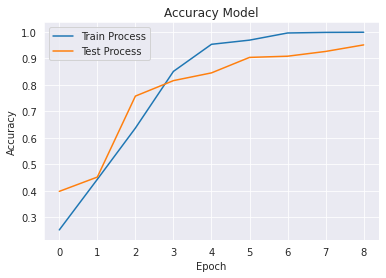

In [49]:
# plot of accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Process', 'Test Process'], loc='upper left')
plt.show()

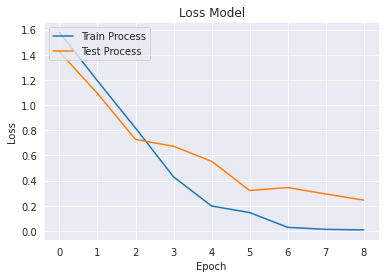

In [50]:
# plot of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Process', 'Test Process'], loc='upper left')
plt.show()